<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/linukc/master_dlcourse/main/images/logo.png">
</p>

 # **[MIPT DL frameworks Spring 2024](https://wiki.cogmodel.mipt.ru/s/mtai/doc/2024-nejrosetevye-frejmvorki-glubokogo-obucheniya-ZBGd69bxLd). Class 1: MLP p.1**

This colab notebook provides code for the first part of the Multilayer Perceptron (MLP) talk.

## **Goals**

In this assignment, you will practice coding a backend of every deep learning framework. The goals of this assignment are as follows:
- create a custom autograd library for simple mathematical operators
- apply it to a MLP to backpropogate signals with a chain rule

## **Contents**

There are two main sections in this lab: **Toying with a basic neurons** and **Custom autograd library**.

There are 4 questions in total:
- for *Toying with a basic neurons*, there are **4** questions (Question 1-4)
- for *Autograd library*, there are no additional questions

### **Setup**

In [27]:
!python3 --version

Python 3.10.12


In [28]:
!python -m pip list | grep numpy

numpy                            1.23.5


In [29]:
!python -m pip list | grep torch

torch                            2.1.0+cu121
torchaudio                       2.1.0+cu121
torchdata                        0.7.0
torchsummary                     1.5.1
torchtext                        0.16.0
torchvision                      0.16.0+cu121


In [30]:
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_moons, make_blobs

### **Toying with a basic neurons**

In [31]:
def heaviside(value):
  return 0 if value <= 0 else 1

class SimpleNeuron:
  def __init__(self, weights, bias=0,
               activation=lambda value: value):
    self.weights = weights
    self.bias = bias
    self.activation = activation

  def __call__(self, inputs):
    return self.activation(
        sum([i * j for i, j in zip(self.weights, inputs)]) + self.bias)

In [32]:
SimpleNeuron(weights=[2, 5])(inputs=[4, 5])

33

In [33]:
SimpleNeuron(weights=[2, 5], bias=-1, activation=heaviside)(inputs=[0, 0])

0

#### *Question 1*

Create SimpleNeuron that can act as a boolean NOT operator.

Hint: solve an equation system.

In [34]:
neuron = SimpleNeuron(weights=[-1], bias=1, activation=heaviside)

In [35]:
assert neuron(inputs=[0]) == 1, f"{neuron(inputs=[0])} is not equal to {1}"
assert neuron(inputs=[1]) == 0, f"{neuron(inputs=[1])} is not equal to {0}"

print("passed all tests")

passed all tests


#### *Question 2*

Create SimpleNeuron that can act as a boolean AND operator.

Hint: solve an equation system.

In [36]:
neuron = SimpleNeuron(weights=[1, 1], bias=-1, activation=heaviside)

In [37]:
assert neuron(inputs=[0, 0]) == 0, f"{neuron(inputs=[0, 0])} is not equal to {0}"
assert neuron(inputs=[0, 1]) == 0, f"{neuron(inputs=[0, 1])} is not equal to {0}"
assert neuron(inputs=[1, 0]) == 0, f"{neuron(inputs=[1, 0])} is not equal to {0}"
assert neuron(inputs=[1, 1]) == 1, f"{neuron(inputs=[1, 1])} is not equal to {1}"

print("passed all tests")

passed all tests


#### *Question 3*

Create SimpleNeuron that can act as a boolean OR operator.

Hint: solve an equation system.

In [38]:
neuron = SimpleNeuron(weights=[1, 1], bias=0, activation=heaviside)

In [39]:
assert neuron(inputs=[0, 0]) == 0, f"{neuron(inputs=[0, 0])} is not equal to {0}"
assert neuron(inputs=[0, 1]) == 1, f"{neuron(inputs=[0, 1])} is not equal to {1}"
assert neuron(inputs=[1, 0]) == 1, f"{neuron(inputs=[1, 0])} is not equal to {1}"
assert neuron(inputs=[1, 1]) == 1, f"{neuron(inputs=[1, 1])} is not equal to {1}"

print("passed all tests")

passed all tests


#### *Question 4*

Create SimpleNeuron that can act as a boolean XOR operator.

In [40]:
class NeuronXOR:
  def __call__(self, inputs):
    not_x = SimpleNeuron(weights=[-1], bias=1, activation=heaviside)([inputs[0]])
    x = inputs[0]

    not_y = SimpleNeuron(weights=[-1], bias=1, activation=heaviside)([inputs[1]])
    y = inputs[1]

    not_x_and_y = SimpleNeuron(weights=[1, 1], bias=-1, activation=heaviside)(inputs=[not_x, y])
    not_y_and_x = SimpleNeuron(weights=[1, 1], bias=-1, activation=heaviside)(inputs=[not_y, x])

    return SimpleNeuron(weights=[1, 1], bias=0, activation=heaviside)(
        inputs=[not_x_and_y, not_y_and_x])

neuron = NeuronXOR()

In [41]:
assert neuron(inputs=[0, 0]) == 0, f"{neuron(inputs=[0, 0])} is not equal to {0}"
assert neuron(inputs=[0, 1]) == 1, f"{neuron(inputs=[0, 1])} is not equal to {1}"
assert neuron(inputs=[1, 0]) == 1, f"{neuron(inputs=[1, 0])} is not equal to {1}"
assert neuron(inputs=[1, 1]) == 0, f"{neuron(inputs=[1, 1])} is not equal to {0}"

print("passed all tests")

passed all tests


### **Custom autograd library**

https://github.com/karpathy/micrograd

<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/karpathy/micrograd/master/puppy.jpg">
</p>

In [42]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [43]:
a = Value(2.0)
b = Value(3.0)
c = a * b
d = Value(5.0)
e = d * c
e.backward()

In [44]:
x = Value(-4.0)
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backward()
xmg, ymg = x, y

x = torch.Tensor([-4.0]).double()
x.requires_grad = True
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backward()
xpt, ypt = x, y

# forward pass went well
assert ymg.data == ypt.data.item()
# backward pass went well
assert xmg.grad == xpt.grad.item()

print("passed all tests")

passed all tests


In [45]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
g.backward()
amg, bmg, gmg = a, b, g

a = torch.Tensor([-4.0]).double()
b = torch.Tensor([2.0]).double()
a.requires_grad = True
b.requires_grad = True
c = a + b
d = a * b + b**3
c = c + c + 1
c = c + 1 + c + (-a)
d = d + d * 2 + (b + a).relu()
d = d + 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g = g + 10.0 / f
g.backward()
apt, bpt, gpt = a, b, g

tol = 1e-6
# forward pass went well
assert abs(gmg.data - gpt.data.item()) < tol
# backward pass went well
assert abs(amg.grad - apt.grad.item()) < tol
assert abs(bmg.grad - bpt.grad.item()) < tol

print("passed all tests")

passed all tests


In [46]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [47]:
seed = 2024
np.random.seed(seed)
random.seed(seed)

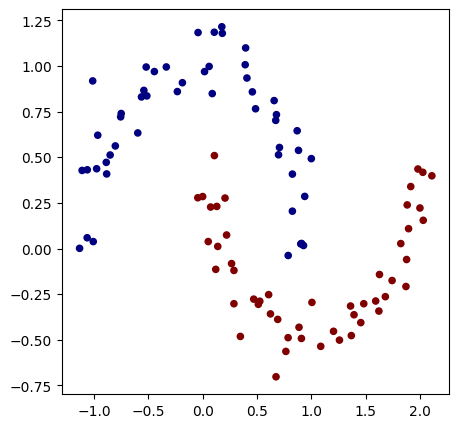

In [48]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [49]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [50]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9572657927863953, grad=0) 0.54


In [51]:
# optimization
for k in range(25):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9572657927863953, accuracy 54.0%
step 1 loss 0.5395986641441692, accuracy 79.0%
step 2 loss 0.3797997096884869, accuracy 87.0%
step 3 loss 0.513783837173646, accuracy 82.0%
step 4 loss 0.2981954725635459, accuracy 84.0%
step 5 loss 0.3298985257023972, accuracy 86.0%
step 6 loss 0.2843190510095551, accuracy 85.0%
step 7 loss 0.3751707301900976, accuracy 87.0%
step 8 loss 0.2523566136319422, accuracy 88.0%
step 9 loss 0.28408330694866707, accuracy 91.0%
step 10 loss 0.23813563082520003, accuracy 88.0%
step 11 loss 0.32297722794105455, accuracy 88.0%
step 12 loss 0.19985689362034909, accuracy 91.0%
step 13 loss 0.22143319671611308, accuracy 92.0%
step 14 loss 0.22946878090675263, accuracy 90.0%
step 15 loss 0.4343065590980976, accuracy 86.0%
step 16 loss 0.2536587550170382, accuracy 89.0%
step 17 loss 0.23018470497501922, accuracy 93.0%
step 18 loss 0.14469586250667457, accuracy 94.0%
step 19 loss 0.127215314722356, accuracy 95.0%
step 20 loss 0.1322928403578637, accuracy 97

(-1.7023042238416939, 2.047695776158306)

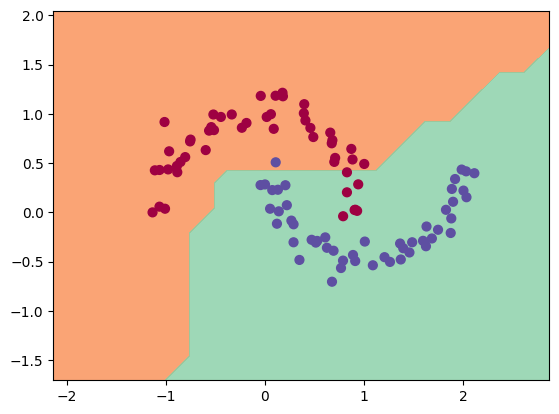

In [52]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())